In [1]:
import os
import json
import numpy as np
import pandas as pd
import gspread
from google.oauth2.service_account import Credentials
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
SERVICE_ACCOUNT_FILE = "predis-475413-8fe8b46b86fc.json"

if os.path.exists(SERVICE_ACCOUNT_FILE):
    print("✅ Utilisation du fichier JSON local pour l'auth Google")
    creds = Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE,
        scopes=["https://www.googleapis.com/auth/spreadsheets",
                "https://www.googleapis.com/auth/drive"]
    )
else:
    print("⚡ Fichier JSON local non trouvé, utilisation du secret GitHub")
    sa_info_json = os.environ["GOOGLE_SERVICE_ACCOUNT_JSON"]
    sa_info = json.loads(sa_info_json)
    creds = Credentials.from_service_account_info(
        sa_info,
        scopes=["https://www.googleapis.com/auth/spreadsheets",
                "https://www.googleapis.com/auth/drive"]
    )

gc = gspread.authorize(creds)

# ============================================================
# 2️⃣ OUVRIR LE GOOGLE SHEET
# ============================================================
sheet_url = "https://docs.google.com/spreadsheets/d/1PdnadzZswADLqGBrI53a_8IsegivCMSz1pCZOh384-Y/edit?gid=1517184233#gid=1517184233"
spreadsheet = gc.open_by_url(sheet_url)
worksheet = spreadsheet.get_worksheet(0)

# ============================================================
# 3️⃣ CHARGEMENT ET PRÉTRAITEMENT DES DONNÉES
# ============================================================
data = worksheet.get_all_values()

header = data[0]
for i, h in enumerate(header):
    if h == "" or header.count(h) > 1:
        header[i] = f"col_{i+1}"

df_fe = pd.DataFrame(data[1:], columns=header)

for col in df_fe.columns:
    df_fe[col] = pd.to_numeric(df_fe[col], errors="ignore")

df_fe = df_fe.drop(columns=['Est. Win'], errors='ignore')
df_fe["R"] = df_fe["R"].replace(0, np.nan)
df_fe = df_fe.dropna(subset=['R'])

print("✅ Données importées depuis le Google Sheet :", df_fe.shape)

# ============================================================
# 4️⃣ CONSTRUCTION DES LAGS
# ============================================================
cols_needed = ["Team Gap Early", "R", "Perf intrinsèque"]
WINDOW = 7

for lag in range(1, WINDOW + 1):
    for col in cols_needed:
        df_fe[f"{col}_lag{lag}"] = df_fe[col].shift(lag)

df_fe = df_fe.fillna(0)
df_fe["LoseStreak"] = (df_fe["Team Gap Early"].astype(float) < 0).astype(int)
df_fe["LoseStreak"] = df_fe["LoseStreak"].rolling(3, min_periods=1).sum()

# ============================================================
# 5️⃣ STANDARDISATION ET ENTRAÎNEMENT DU RANDOM FOREST
# ============================================================
feature_columns_final = [
    f"{col}_lag{lag}" for col in cols_needed for lag in range(1, WINDOW + 1)
] + ["LoseStreak"]

X = df_fe[feature_columns_final].fillna(0)
y = df_fe["Team Gap Early"].astype(float)

scaler_all = StandardScaler()
X_scaled = scaler_all.fit_transform(X)

rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_scaled, y)

y_train = y.values
print("✅ RandomForest entraîné sur tout l'historique :", len(y_train), "échantillons")

# ============================================================
# 6️⃣ PRÉDICTIONS DES 2 PROCHAINES GAMES
# ============================================================
def build_X_from_window(window_df, feature_cols, window):
    next_row = {}
    for col in ["Team Gap Early", "R", "Perf intrinsèque"]:
        for lag in range(1, window + 1):
            next_row[f"{col}_lag{lag}"] = window_df[col].iloc[-lag]
    lose_series = (window_df["Team Gap Early"].astype(float) < 0).astype(int)
    next_row["LoseStreak"] = int(lose_series.rolling(3, min_periods=1).sum().iloc[-1])
    return pd.DataFrame([next_row])[feature_cols].fillna(0).values

def map_to_20_80(pred, y_min, y_max):
    pred_clipped = np.clip(pred, y_min, y_max)
    return 20 + 60 * ((pred_clipped - y_min) / (y_max - y_min + 1e-9))

def predict_next_n_games_rf(model, df_fe, n_future=2):
    df_extended = df_fe.copy()
    preds = []
    for i in range(n_future):
        window_df = df_extended.iloc[-WINDOW:]
        X_plate = build_X_from_window(window_df, feature_columns_final, WINDOW)
        X_scaled = scaler_all.transform(X_plate)
        pred = float(model.predict(X_scaled)[0])
        preds.append(pred)
        new_row = {col: np.nan for col in df_fe.columns}
        new_row["Team Gap Early"] = pred
        new_row["R"] = 0.0
        new_row["Perf intrinsèque"] = 0.0
        df_extended = pd.concat([df_extended, pd.DataFrame([new_row])], ignore_index=True)
    return preds, df_extended

preds_future, df_fe_extended = predict_next_n_games_rf(rf, df_fe, n_future=2)

print("\n🎯 PRÉDICTIONS DES PROCHAINES GAMES (valeurs réelles, regression) :")
for i, p in enumerate(preds_future, 1):
    print(f"Game +{i}: {p:.4f}")

# Mapper en 20-80
y_min, y_max = y_train.min(), y_train.max()
preds_future_mapped = [map_to_20_80(p, y_min, y_max) for p in preds_future]
print("Mapped 20-80 (linear):", preds_future_mapped)

# ============================================================
# 7️⃣ ÉCRITURE DANS LE GOOGLE SHEET
# ============================================================
values = [[float(v)] for v in preds_future_mapped]
start_row = len(df_fe) + 2
col_letter = "D"
col_name = "Pred_TeamGapEarly_Next"

worksheet.update(values=[[col_name]], range_name=f"{col_letter}1")
worksheet.update(
    values=values,
    range_name=f"{col_letter}{start_row}:{col_letter}{start_row + len(values) - 1}"
)

print("✅ Prédictions écrites dans le Google Sheet (colonne", col_letter, ")")


✅ Utilisation du fichier JSON local pour l'auth Google
✅ Données importées depuis le Google Sheet : (65, 10)
✅ RandomForest entraîné sur tout l'historique : 65 échantillons

🎯 PRÉDICTIONS DES PROCHAINES GAMES (valeurs réelles, regression) :
Game +1: -0.4300
Game +2: -1.1200
Mapped 20-80 (linear): [43.5499999941125, 33.1999999967]


C:\Users\Rafael\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Rafael\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Prédictions écrites dans le Google Sheet (colonne D )


### Bonus matrice de corrélation

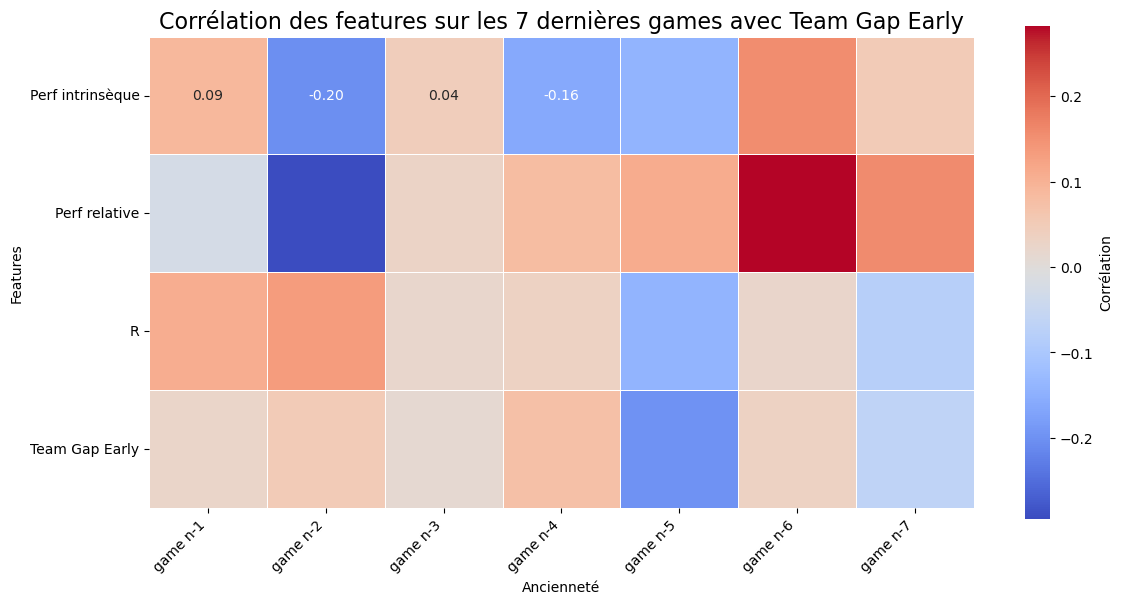

In [3]:

features = ['R', 'Perf relative', 'Perf intrinsèque', 'Team Gap Early']
target = 'Team Gap Early'
max_lag = 7

df_lagged = df_fe.copy()

# Créer les colonnes lag
for feat in features:
    for lag in range(1, max_lag + 1):
        df_lagged[f'{feat}_lag{lag}'] = df_lagged[feat].shift(lag)

# Supprimer les lignes avec target NaN
df_corr = df_lagged.dropna(subset=[target])

# Calcul des corrélations
corr_dict = {}
for feat in features:
    for lag in range(1, max_lag + 1):
        corr_dict[f'{feat}_lag{lag}'] = df_corr[target].corr(df_corr[f'{feat}_lag{lag}'])

corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['Correlation'])
corr_df['Feature'] = [name.split('_lag')[0] for name in corr_df.index]
corr_df['Lag'] = [int(name.split('_lag')[1]) for name in corr_df.index]

# Pivot pour heatmap
heatmap_data = corr_df.pivot(index='Feature', columns='Lag', values='Correlation')

# Heatmap avec labels
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Corrélation'},
    linewidths=0.5,
    square=True
)

# Forcer les labels pour toutes les cases
ax.set_xticklabels([f"game n-{i}" for i in heatmap_data.columns], rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=10)

plt.title('Corrélation des features sur les 7 dernières games avec Team Gap Early', fontsize=16)
plt.xlabel('Ancienneté')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
